In [14]:
import binascii
import re
import string

In [15]:
exclude = set(string.punctuation)

In [16]:
def parse_data(filename):
    ans = []
    with open("data/" + filename, "r") as f:
        # read lines from filename
        for line in f:
            if line[-1] == "\n":
                line = line[:-1]
            m = re.search(r't\d+', line)
            doc_id = m.group()
            doc = line[len(doc_id):].lower().replace(" ", "")
            doc = ''.join(ch for ch in doc if ch not in exclude)
            ans.append((doc_id, doc))
    return ans

In [17]:
def shingle_document(string, k):
    shingles_in_doc = set()
    for index in range(len(string) - k + 1):
        shingles = string[index:index + k]
        crc = binascii.crc32(bytes(shingles, encoding="utf-8"))
        shingles_in_doc.add(crc)
    return shingles_in_doc

In [18]:
def jaccard(a: set, b: set):
    # compute union size
    u = a.union(b)
    # compute intersection size
    i = a.intersection(b)
    return len(i) / len(u)

In [19]:
def compute_docs_JSim(filename, k):
    docs = parse_data(filename)
    doc_num = len(docs)
    ans = []
    for i in range(doc_num):
        doc_id, doc = docs[i]
        doc_shingles = shingle_document(doc, k)
        for j in range(i + 1, doc_num):
            compared_doc_id, compared_doc = docs[j]
            compared_doc_shingles = shingle_document(compared_doc, k)
            j_sim = jaccard(doc_shingles, compared_doc_shingles)
            ans.append((doc_id, compared_doc_id, j_sim))
    return ans

In [20]:
def get_mean_data(train, truth, n):
    truth_data = parse_data(truth)
    ans = []
    for k in range(1, n + 1):
        doc_js = compute_docs_JSim(train, k)
        abbr_dict = {tuple(item[0:2]): item[2] for item in doc_js}
        sum_train, sum_truth = 0, 0
        for i in range(len(truth_data) - 1):
            sum_truth += abbr_dict[(truth_data[i])]
        mean_truth = sum_truth / len(truth_data)
        for j in range(len(doc_js) - 1):
            sum_train += doc_js[j][2]
        mean_train = (sum_train - sum_truth) / (len(doc_js) - len(truth_data))
        ans.append((k, mean_train, mean_truth))
    return ans

In [21]:
def draw_mean_plot(filename_train, filename_truth, n):
    import matplotlib.pyplot as plt
    import pandas as pd
    mean_plot = get_mean_data(filename_train, filename_truth, n)
    df = pd.DataFrame(mean_plot)
    df.columns = ["k", "non-plagiarism instances", "plagiarism instances"]

    plt.plot('k', 'non-plagiarism instances', data=df, color='green')
    plt.plot('k', 'plagiarism instances', data=df, color='red')

    plt.xlabel('k value')
    plt.ylabel('average Jaccard similarity')

    plt.title('Plagiarism and Non-Plagiarism Articles\'\nJaccard Similarity Comparison\n')
    plt.legend()
    plt.show()

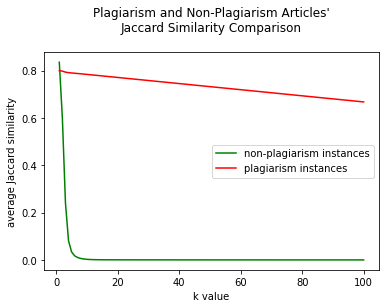

In [22]:
TRAIN = "articles_100.train"
TRUTH = "articles_100.truth"
draw_mean_plot(TRAIN, TRUTH, 100)